# Introduction aux processus gaussiens

Date: 6 février 2025

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Importer jax

In [2]:
import jax

jax.config.update("jax_enable_x64", True)

In [3]:
! pip install tinygp

Importer `tinygp` (*package de GP compatible avec Jax*) et créer un kernel (*groupe de fonctions*)

In [4]:
from tinygp import kernels

kernel = kernels.ExpSquared(scale=1.5)

Nous venons de créer un "Squared Exponential Kernel", voici sa forme mathématique: 

$
k(x, x') = \sigma^2 \exp \left( -\frac{(x - x')^2}{2\ell^2} \right)
$

Nous allons maintenant mettre en graphique des échantillons des fonctions tirées de ce kernel. C'est en quelque sorte un portrait de famille du kernel. 


In [5]:
from tinygp import GaussianProcess

# Let's make up some input coordinates (sorted for plotting purposes)
X = np.sort(np.random.default_rng(1).uniform(0, 10, 1000))

gp = GaussianProcess(kernel, X)

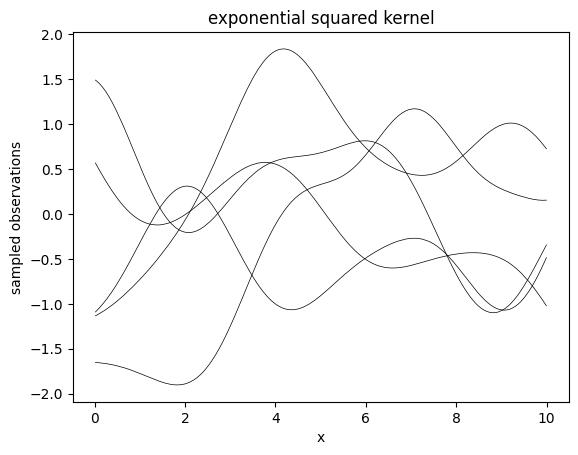

In [6]:
y = gp.sample(jax.random.PRNGKey(4), shape=(5,))
plt.plot(X, y.T, color="k", lw=0.5)
plt.xlabel("x")
plt.ylabel("sampled observations")
_ = plt.title("exponential squared kernel")

Il se trouve que l'on peut multiplier ou additionner des kernel ensemble afin de "mixer" les propriétés de chacun. Ici par exemple, nous multiplions le kernel exponentiel à un kernel cosinus. Les échantillons devraient donc ressembler à une version plus périodique des échantillons précédents. 

$
k(x, x') = \sigma^2 \exp \left( -\frac{(x - x')^2}{2\ell^2} \right) \cos \left( \frac{2\pi |x - x'|}{P} \right)
$


- $\sigma^2$ est l'amplitude du kernel. Ce paramètre contrôle la variance maximale du processus gaussien généré par ce kernel. Une valeur plus élevée permet d'explorer des amplitudes de fonction plus grandes.
  
- $\ell$ est la longueur de corrélation (ou échelle de corrélation). Elle détermine à quelle distance deux points \( x \) et \( x' \) restent corrélés. Une valeur de $\ell$ grande signifie que la fonction varie lentement, tandis qu'une valeur faible signifie que la fonction peut présenter des variations rapides.

-  $P$ est la période du terme cosinus. Il impose une périodicité aux corrélations, ce qui est utile pour modéliser des phénomènes quasi-périodiques comme les oscillations stellaire ou l'activité stellaire.



In [7]:
kernel_prod = 2 * kernels.ExpSquared(scale=1.5) * kernels.Cosine(scale=2.5)
gp = GaussianProcess(kernel_prod, X, diag=1e-5)

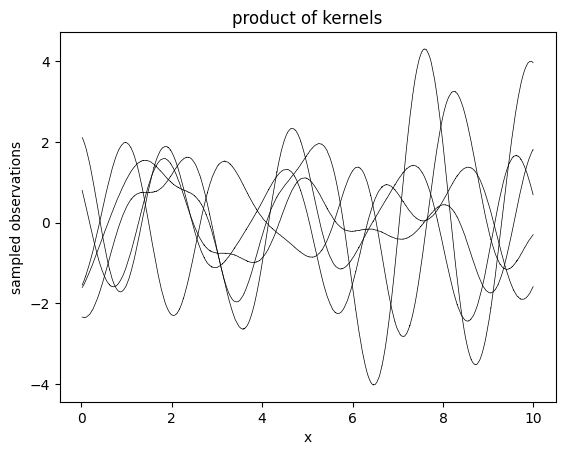

In [8]:
y = gp.sample(jax.random.PRNGKey(4), shape=(5,))

plt.plot(X, y.T, color="k", lw=0.5)
plt.xlabel("x")
plt.ylabel("sampled observations")
_ = plt.title("product of kernels")

Ce kernel est particulièrement utile dans le cadre de la modélisation de signaux quasi-périodiques avec une composante de décroissance exponentielle. Le terme exponentiel assure une corrélation décroissante avec la distance, tandis que le terme cosinus introduit une structure périodique. Cela permet de capturer des phénomènes où une période caractéristique est présente, mais avec des variations d'amplitude au fil du temps.


## Kernel quasi-périodique (QP)

Une alternative plus flexible est le kernel quasi-périodique (QP), qui combine un kernel exponentiel quadratique avec un terme de forme exponentielle en sinus au carré :

$
k(x, x') = \sigma^2 \exp \left( -\frac{(x - x')^2}{2\ell^2} \right) \exp \left( -\frac{2 \sin^2 \left( \frac{\pi |x - x'|}{P} \right)}{\Gamma^2} \right).
$

Ce kernel introduit un paramètre supplémentaire $\Gamma$, qui contrôle la régularité des oscillations d'un cycle à l'autre :

- $\sigma^2$ : amplitude du kernel, contrôle la variance du processus. Représente l'intensité de l'activité stellaire.
- $\ell$ : échelle de corrélation globale, détermine la durée sur laquelle le signal reste cohérent avant de changer significativement. Relier aux temps de vie des taches. 
- $P$ : période caractéristique du signal. Période de rotation de l'étoile.
- $\Gamma$ : paramètre de régularité de la périodicité, qui contrôle dans quelle mesure la forme des cycles individuels peut varier. Une valeur élevée de $\Gamma$ impose une périodicité plus rigide, tandis qu’une valeur faible permet aux cycles d'évoluer plus librement. Relier aux nombres de taches. 

## Pourquoi le kernel quasi-périodique est plus adapté à l'activité stellaire

L'activité stellaire, due aux taches stellaires et aux variations de l'émission convective, produit un signal quasi-périodique plutôt que strictement périodique. Cela signifie que :

- La période du signal reste approximativement constante, mais la forme du signal peut changer légèrement au fil du temps en raison de l'évolution des taches stellaires.
- L’amplitude des variations n’est pas parfaitement régulière, car les structures de surface de l’étoile changent.
- Un modèle strictement sinusoïdal (cosinus) impose une périodicité rigide qui ne reflète pas ces variations naturelles.

Le kernel quasi-périodique permet de capturer ces effets en combinant une périodicité bien définie avec une souplesse dans la variation des cycles, ce qui en fait un choix plus approprié pour la modélisation de l'activité stellaire.

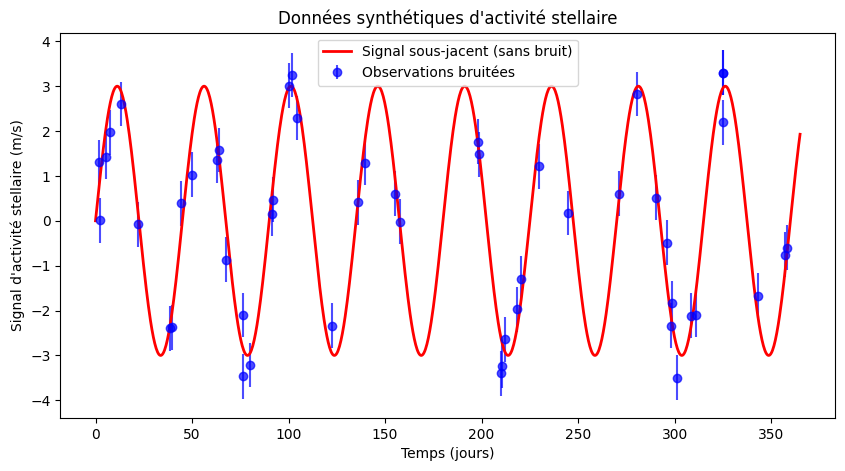

In [9]:
# Paramètres du signal d'activité stellaire
P = 45.0  # Période dominante (jours)
amp = 3.0  # Amplitude principale (m/s)
sigma_noise = 0.5  # Niveau de bruit (m/s)

# Génération d'un temps d'observation irrégulier
np.random.seed(100)
t = np.sort(np.random.uniform(0, 365, 50))  # 50 observations réparties sur un an

# Définition du signal sous-jacent
def stellar_activity_signal(t, P, amp):
    """Génère un signal d'activité stellaire basé sur des fonctions sinusoïdales."""
    signal = amp * np.sin(2 * np.pi * t / P)  # Sinusoïde principale
    #signal += amp2 * np.sin(2 * np.pi * t / P2 + 2 * phase_drift)  # Ajout d'une harmonique
    return signal

# Génération du signal
y_true = stellar_activity_signal(t, P, amp)

# Ajout du bruit de mesure
y_obs = y_true + np.random.normal(0, sigma_noise, len(t))
y_err = np.ones_like(y_obs) * sigma_noise

tsmooth = np.linspace(0, 365, 1000)
y_true_smooth = stellar_activity_signal(tsmooth, P, amp)

# Affichage des données simulées
plt.figure(figsize=(10, 5))
plt.errorbar(t, y_obs, yerr=sigma_noise, fmt='o', label="Observations bruitées", color='b', alpha=0.7)
plt.plot(tsmooth, y_true_smooth, label="Signal sous-jacent (sans bruit)", color='r', linewidth=2)
plt.xlabel("Temps (jours)")
plt.ylabel("Signal d'activité stellaire (m/s)")
plt.title("Données synthétiques d'activité stellaire")
plt.legend()
plt.show()


Nous allons créer un GP qui va tenter de modéliser ce signal d'activité. 

In [10]:
import jax.numpy as jnp

# GP quasi-périodique
def build_gp(theta, time):
    """
    Build a Gaussian Process with a quasi-periodic kernel for stellar activity in RV data.

    Parameters:
        theta (dict): A dictionary of parameters for the kernel and GP.
            Keys:
                - "log_amp" (float): Logarithm of the amplitude of the GP.
                - "log_scale" (float): Logarithm of the scale length for the smooth component.
                - "log_period" (float): Logarithm of the periodic component's period.
                - "log_gamma" (float): Logarithm of the decay timescale for the periodic component.
                - "log_diag" (float): Logarithm of the diagonal noise term.
                - "mean" (float): Mean value of the GP.
        time (array-like): Array of time points for the RV data.

    Returns:
        GaussianProcess: A GaussianProcess object with the quasi-periodic kernel.
    """
    # Extract parameters and transform to positive space where needed
    amp = jnp.exp(theta["log_amp"]) #amplitude du signal d'activité [m/s]
    scale = jnp.exp(theta["log_scale"]) #relié au temps de vie des tâches [jours]
    period = jnp.exp(theta["log_period"]) #période de rotation de l'étoile [jours]
    gamma = jnp.exp(theta["log_gamma"]) #relié au nombre de tâche stellaire 
    diag = jnp.exp(theta["log_diag"]) #modèle du white noise [m/s]
    mean = theta["mean"] #moyenne du signal [m/s]

    # Define the quasi-periodic kernel
    kernel = (
        amp
        * kernels.ExpSquared(scale)
        * kernels.ExpSineSquared(scale=period, gamma=gamma)
    )

    # Build the Gaussian Process
    gp = GaussianProcess(kernel, time, diag=diag, mean=mean)

    return gp

Create the GP, it's here that you have to choose the hyperparameters. 

In [ ]:
gp = build_gp(
    {
        "log_amp": jnp.log(3.0),
        "log_scale": jnp.log(400.0),
        "log_period": jnp.log(45.0),
        "log_gamma": jnp.log(1),
        "log_diag": jnp.log(sigma_noise),
        "mean": 0.0,
    },
    t,*9
)

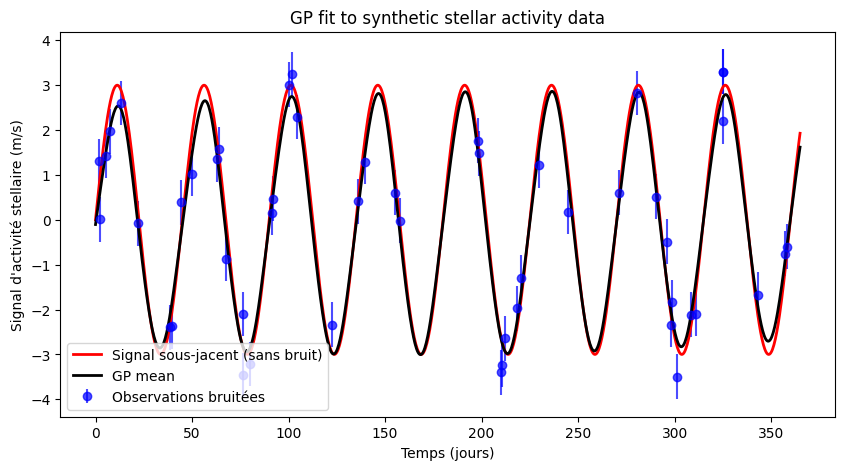

In [12]:
# Plot the predicted GP mean and variance
mu = gp.predict(y_obs, tsmooth)

plt.figure(figsize=(10, 5))
plt.errorbar(t, y_obs, yerr=sigma_noise, fmt='o', label="Observations bruitées", color='b', alpha=0.7)
plt.plot(tsmooth, y_true_smooth, label="Signal sous-jacent (sans bruit)", color='r', linewidth=2)
plt.plot(tsmooth, mu, label="GP mean", color='k', linewidth=2)
#plt.fill_between(tsmooth, mu - 2 * std, mu + 2 * std, color='k', alpha=0.2, label="GP 2σ interval")
plt.xlabel("Temps (jours)")
plt.ylabel("Signal d'activité stellaire (m/s)")
plt.title("GP fit to synthetic stellar activity data")
plt.legend()
plt.show()

### **Comment trouver les hyperparamètres ayant le mieux avec les données...?** 

À vous de jouer! 

In [13]:
import jax
import jax.numpy as jnp
import numpyro

import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from astropy.table import Table
from jaxoplanet.orbits import keplerian
from jaxoplanet.units import unit_registry as ureg
from numpyro import distributions as dist, infer
from jax import jit  # Ensure JIT is imported

import yaml

In [14]:
numpyro.set_host_device_count(20)
jax.config.update("jax_enable_x64", True)

In [58]:
def jax_model(time, y_obs=None, y_err=None):

    log_amp = numpyro.sample('log_amp', dist.Uniform(jnp.log(0.00001), jnp.log(100)))
    log_scale = numpyro.sample('log_scale', dist.Uniform(jnp.log(300), jnp.log(400)))
    log_period = numpyro.sample('log_period', dist.Uniform(jnp.log(40), jnp.log(50)))
    log_gamma =  numpyro.sample('log_gamma', dist.Uniform(jnp.log(0.00001), jnp.log(10)))
    log_diag = numpyro.sample('log_diag', dist.Uniform(jnp.log(0.000000001), jnp.log(10)))
    mean = numpyro.sample('mean', dist.Uniform(-50, 50))

    params = {
        "log_amp": log_amp, "log_scale": log_scale, "log_period": log_period, "log_gamma": log_gamma,
        "log_diag": log_diag, "mean": mean,
    }

    # Expected value
    gp = build_gp(params, time)
    
    numpyro.sample("gp", gp.numpyro_dist(), obs= y_obs)

In [59]:
init_values = {
    "log_amp": jnp.log(3),
    "log_scale": jnp.log(365),
    "log_period": jnp.log(45),
    "log_gamma": jnp.log(1),
    "log_diag": jnp.log(sigma_noise),
    "mean": np.float64(0),
}

In [60]:
nuts_model = infer.NUTS(jax_model,  dense_mass = True, regularize_mass_matrix = False, init_strategy=infer.init_to_value(values=init_values))

In [61]:
# Define the number of warm-up steps, samples, and chains
ndim = 6
num_warmup = ndim * 100
num_samples = ndim * 1000
num_chains = 2

# Use NUTS sampler with initialization strategy set to predefined values
nuts_model = infer.NUTS(jax_model, init_strategy = infer.init_to_value(values=init_values))

sampler = infer.MCMC(
    nuts_model,  # Initialize with the defined initial values
    num_warmup=num_warmup,
    num_samples=num_samples,
    num_chains=num_chains,
    progress_bar=True,
)

# Ensure random seed is provided and compatible with JAX
seed = jax.random.PRNGKey(6)

# Run the sampler on the model with time and observed RV data
sampler.run(seed, t, y_obs = y_obs, y_err = y_err)

# Summarize the results
sampler.print_summary()

C:\Users\tabas\AppData\Local\Temp\ipykernel_13928\2083593508.py:10: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = infer.MCMC(
sample: 100%|██████████| 6600/6600 [02:05<00:00, 52.44it/s, 31 steps of size 2.08e-01. acc. prob=0.93]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
     log_amp      2.32      1.07      2.24      0.61      4.11   2574.13      1.00
    log_diag     -1.36      0.23     -1.36     -1.72     -0.96   8694.24      1.00
   log_gamma     -1.00      1.20     -0.99     -2.94      0.99   2806.39      1.00
  log_period      3.81      0.01      3.81      3.79      3.82   8981.21      1.00
   log_scale      5.88      0.08      5.89      5.76      5.99   8741.12      1.00
        mean      0.15      3.32      0.09     -4.75      5.63   5211.18      1.00

Number of divergences: 0


In [21]:
samples = sampler.get_samples()
best_params = {k: jnp.median(v) for k, v in samples.items()}
print(best_params)

{'log_amp': Array(2.24420169, dtype=float64), 'log_diag': Array(-1.3636617, dtype=float64), 'log_gamma': Array(-0.98623931, dtype=float64), 'log_period': Array(3.80643258, dtype=float64), 'log_scale': Array(5.89402882, dtype=float64), 'mean': Array(0.09207496, dtype=float64)}


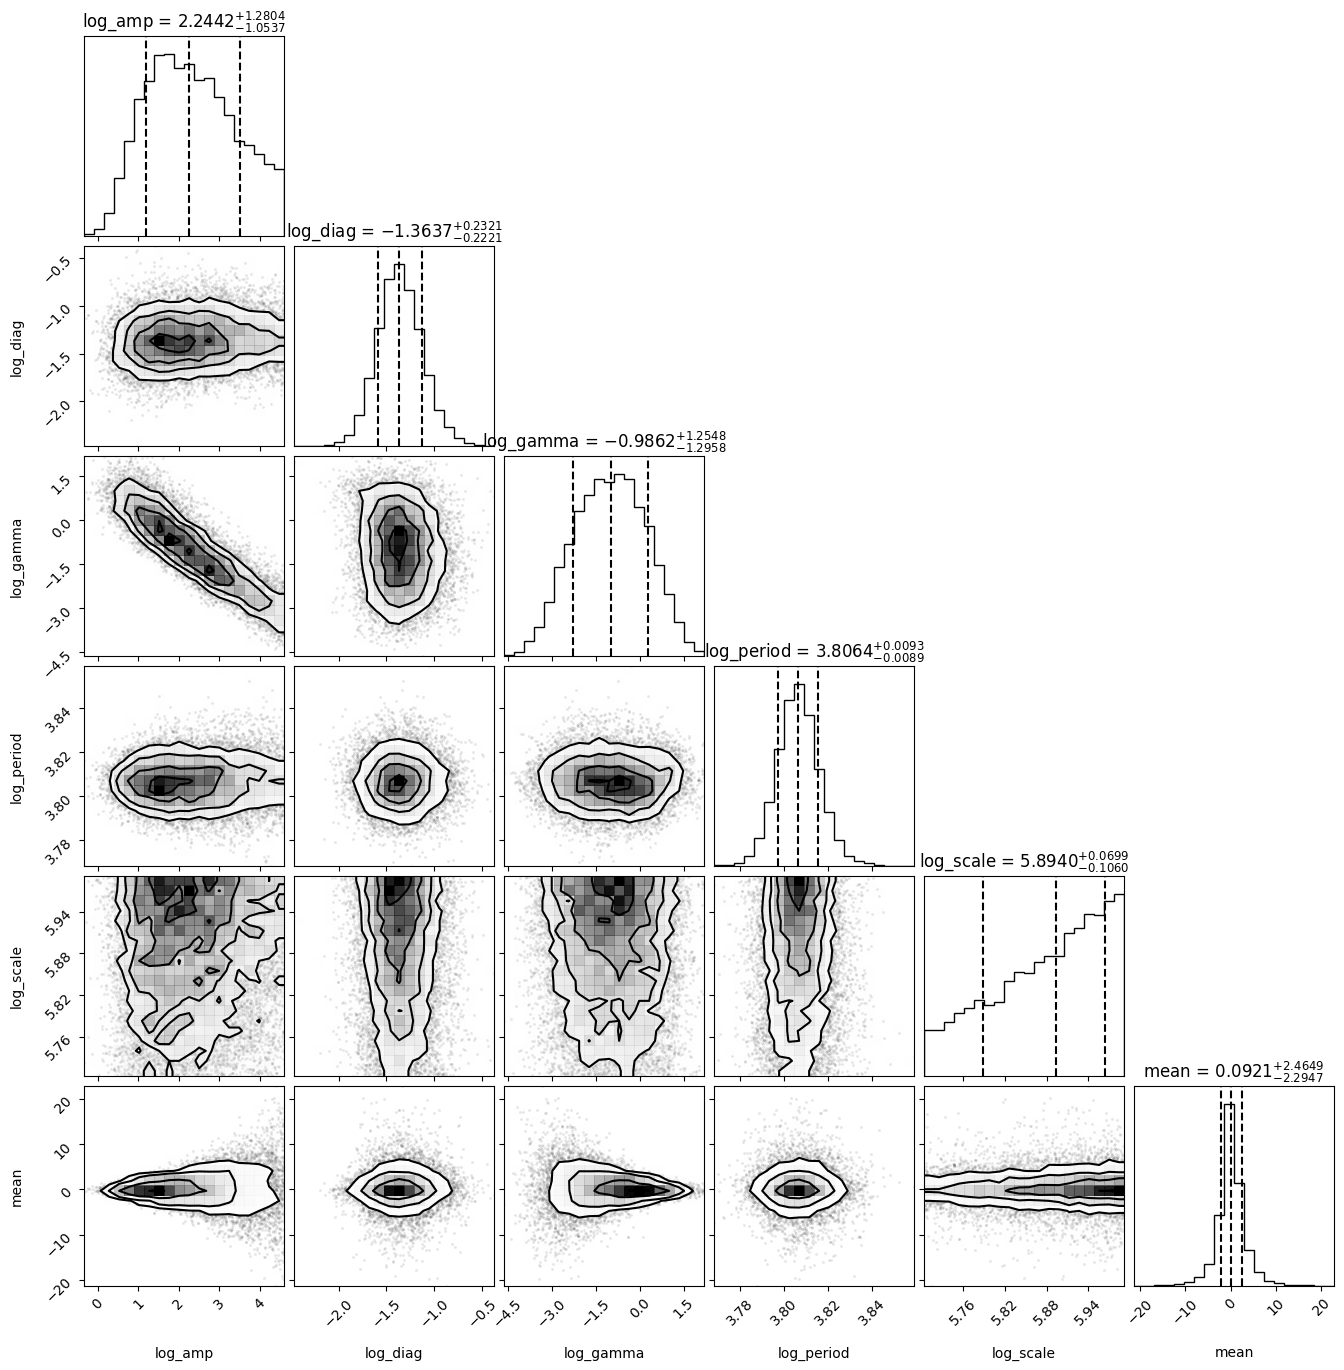

In [22]:
import corner

_ = corner.corner(
    samples,
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_fmt=".4f",
)

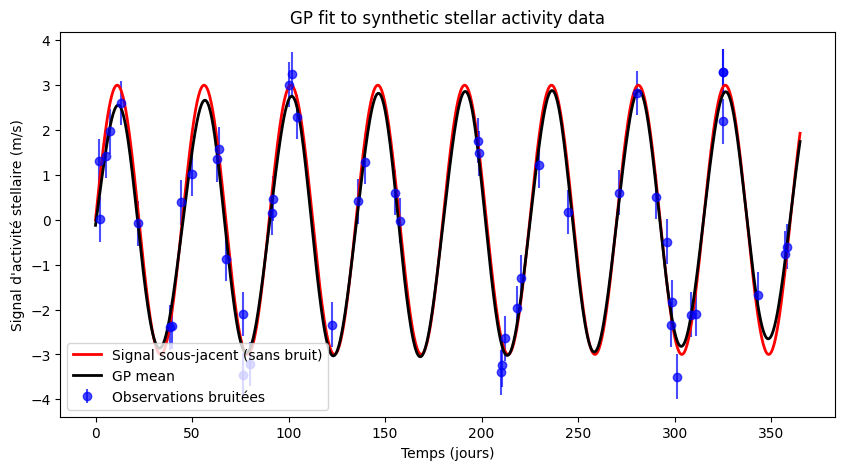

In [38]:
# Generate best-fit line
# time_fit = np.linspace(t.min(), t.max(), 1000)
# y_fit = build_gp(best_params, time_fit)

# # Plot the data points with regular error bars
# plt.errorbar(t, y_obs, yerr=sigma_noise, fmt='o', label='Observation bruitée', color='green')

# # Plot the best-fit line
# plt.plot(time_fit, y_fit, label='Best-fit line', color='red')


# Plot the predicted GP mean and variance
mu = gp.predict(y_obs, tsmooth)

plt.figure(figsize=(10, 5))
plt.errorbar(t, y_obs, yerr=sigma_noise, fmt='o', label="Observations bruitées", color='b', alpha=0.7)
plt.plot(tsmooth, y_true_smooth, label="Signal sous-jacent (sans bruit)", color='r', linewidth=2)
plt.plot(tsmooth, mu, label="GP mean", color='k', linewidth=2)
#plt.fill_between(tsmooth, mu - 2 * std, mu + 2 * std, color='k', alpha=0.2, label="GP 2σ interval")
plt.xlabel("Temps (jours)")
plt.ylabel("Signal d'activité stellaire (m/s)")
plt.title("GP fit to synthetic stellar activity data")
plt.legend()
plt.show()